In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.ensemble import GradientBoostingRegressor, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import KFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
pd.set_option('display.max_columns', 500)
label_encoder = LabelEncoder()

housing_factor_tuned = pd.read_pickle("housing_factor_tuned.pkl")
housing_numeric_scaled = pd.read_pickle("housing_numeric_scaled.pkl")
housing_factor_tuned = housing_factor_tuned.apply(label_encoder.fit_transform)
housing_combined = pd.concat([housing_numeric_scaled,housing_factor_tuned],axis=1)

In [2]:
housing_combined = housing_combined[['GrLivArea', 'YearBuilt', 'TotalBsmtSF', 'Fireplaces', 'TotalBath', 'LotArea', 'MasVnrArea',
                                                             'OverallCond', 'GarageArea', 'YearRemodAdd', 'Foundation',
                                                             'TotRmsAbvGrd', 'GarageYrBlt', 'PoolArea', 'YrSold', 'MoSold', 'LotFrontage', 'OverallQual',
                                                             'BsmtQual', 'KitchenQual', "BsmtExposure", 'FireplaceQu', 'Neighborhood', 'HeatingQC', 'OpenPorchSF']].copy()

In [3]:
housing_numeric = pd.read_pickle("~/Documents/NYCDSA/Third Project/ML_Ames_Housing/Python/housing_numeric.pkl")
SalePrice = housing_numeric['SalePrice']

X_train, X_test, y_train, y_test = train_test_split(housing_combined, SalePrice, test_size=0.2, random_state=42)

kf = KFold(n_splits=5, shuffle=True, random_state=42)
gbm = GradientBoostingRegressor()

In [4]:
cross_val_score_gb = cross_val_score(gbm, housing_combined, SalePrice, scoring = 'r2', cv=kf, n_jobs = -1)
print(cross_val_score_gb)
print('Avg Score:',np.mean(cross_val_score_gb))
print('Variance:',np.var(cross_val_score_gb))

[0.90493063 0.85511438 0.91052842 0.92268284 0.90808569]
Avg Score: 0.9002683921449062
Variance: 0.0005458814186837164


In [5]:
grid_para_gbm = { 
    'n_estimators': [50], 
    'max_features': ['sqrt', 'log2', None], 
    'max_depth': [None], 
    'max_leaf_nodes': [None] 
}
grid_search_gbm = GridSearchCV(gbm, grid_para_gbm, scoring = 'r2', cv= kf, n_jobs = -1)
%time grid_search_gbm.fit(housing_combined, SalePrice)

CPU times: total: 328 ms
Wall time: 2.94 s


GridSearchCV(cv=KFold(n_splits=5, random_state=42, shuffle=True),
             estimator=GradientBoostingRegressor(), n_jobs=-1,
             param_grid={'max_depth': [None],
                         'max_features': ['sqrt', 'log2', None],
                         'max_leaf_nodes': [None], 'n_estimators': [50]},
             scoring='r2')

In [6]:
grid_search_gbm.best_score_

0.8892609825522328

In [7]:
best_estimator = grid_search_gbm.best_estimator_
feature_importance = pd.Series(best_estimator.feature_importances_, index= housing_combined.columns).sort_values(ascending=False).head(28)
feature_importance

OverallQual     0.167380
GrLivArea       0.158835
TotalBsmtSF     0.135348
YearBuilt       0.123877
GarageArea      0.072126
TotalBath       0.037507
YearRemodAdd    0.035010
BsmtQual        0.034602
MasVnrArea      0.030746
Fireplaces      0.030674
LotArea         0.030023
KitchenQual     0.026992
GarageYrBlt     0.024189
LotFrontage     0.016456
TotRmsAbvGrd    0.014649
OpenPorchSF     0.010386
OverallCond     0.009698
Neighborhood    0.009656
BsmtExposure    0.008483
MoSold          0.006497
Foundation      0.006473
YrSold          0.004215
FireplaceQu     0.003008
HeatingQC       0.002857
PoolArea        0.000313
dtype: float64

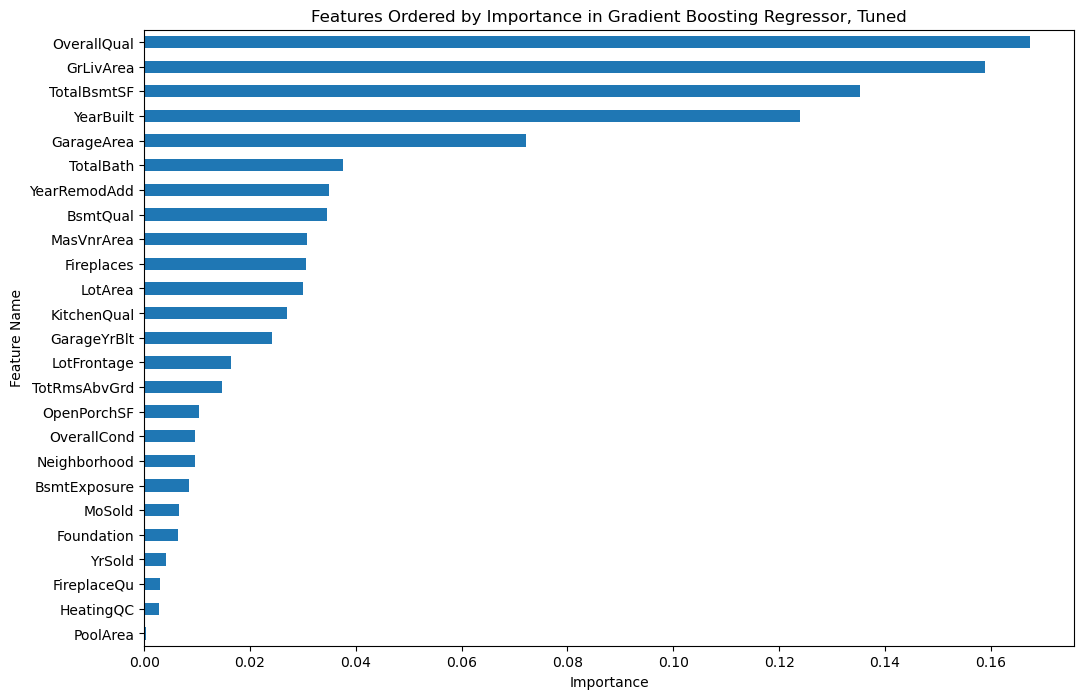

In [8]:
plt.figure(figsize=(12, 8))
feature_importance.plot(kind='barh')
plt.title(f'Features Ordered by Importance in Gradient Boosting Regressor, Tuned')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis() 

In [9]:
from sklearn.model_selection import KFold
fold_scores = []
fold_num = 1
kf = KFold(n_splits=5, shuffle=True, random_state=42)
for train_index, test_index in kf.split(housing_combined):
    
    X_train, X_test = housing_combined.iloc[train_index], housing_combined.iloc[test_index]
    y_train, y_test = SalePrice.iloc[train_index], SalePrice.iloc[test_index]
    
    grid_search = GridSearchCV(gbm, grid_para_gbm, cv=5, scoring='r2', n_jobs = -1, return_train_score=True)
    grid_search.fit(X_train, y_train)
    fold_score = grid_search.score(X_test, y_test)
    best_forest = grid_search.best_estimator_
    print(f'Score for Fold: {fold_num}', fold_score)
    print(f'Best Params for Fold {fold_num}', best_forest)

    # Store best parameters and score
    fold_scores.append({
        'score':fold_score,
        'fold':fold_num})
    fold_num += 1

Score for Fold: 1 0.8963930853409869
Best Params for Fold 1 GradientBoostingRegressor(max_depth=None, max_features='log2', n_estimators=50)
Score for Fold: 2 0.8569865289122517
Best Params for Fold 2 GradientBoostingRegressor(max_depth=None, max_features='log2', n_estimators=50)
Score for Fold: 3 0.8954534499292116
Best Params for Fold 3 GradientBoostingRegressor(max_depth=None, max_features='log2', n_estimators=50)
Score for Fold: 4 0.9039122594811719
Best Params for Fold 4 GradientBoostingRegressor(max_depth=None, max_features='sqrt', n_estimators=50)
Score for Fold: 5 0.8837355086281921
Best Params for Fold 5 GradientBoostingRegressor(max_depth=None, max_features='log2', n_estimators=50)


In [10]:
total_score = 0
for i, el in enumerate(fold_scores):
    total_score += el['score']
    avg_score = total_score / (i+1)
print(avg_score)

0.8872961664583627


In [11]:
gbm.fit(X_train,y_train)

GradientBoostingRegressor()

In [12]:
important_features2 = gbm.feature_importances_
feature_importances2 = pd.Series(important_features2, index=X_train.columns).head(25)
feature_importances2 = feature_importances2.sort_values(ascending=False)

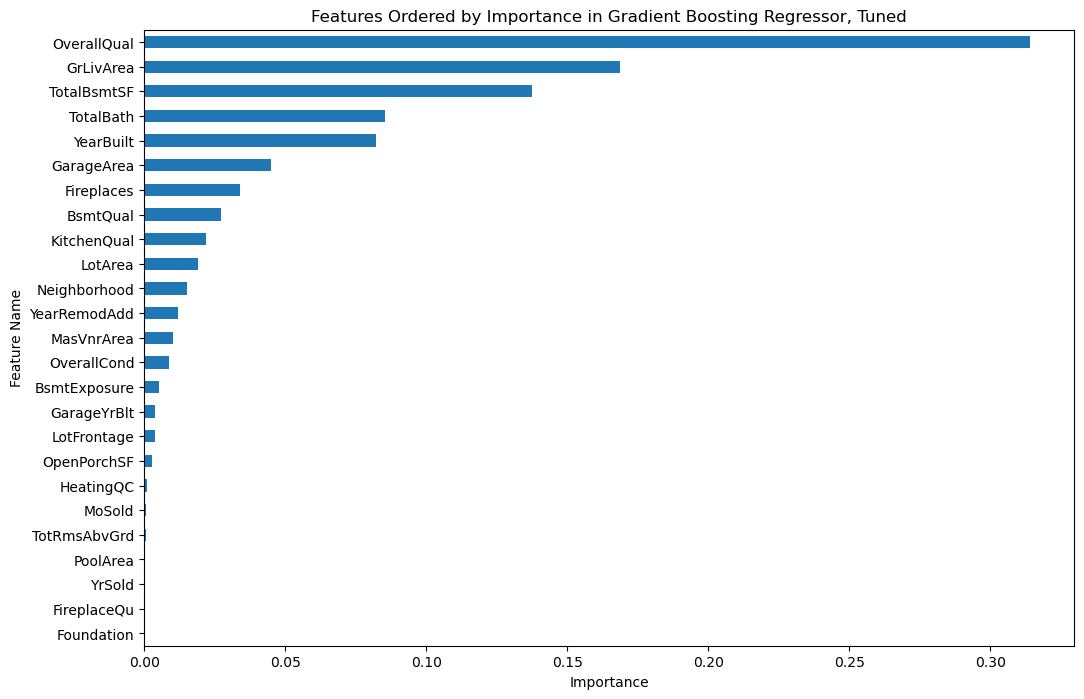

In [13]:
plt.figure(figsize=(12, 8))
feature_importances2.plot(kind='barh')
plt.title(f'Features Ordered by Importance in Gradient Boosting Regressor, Tuned')
plt.xlabel('Importance')
plt.ylabel('Feature Name')
plt.gca().invert_yaxis() 